# Galactic Center TIGRESS model

In [38]:
%matplotlib inline
import numpy as np
from numpy import histogram2d
import matplotlib.pyplot as plt
from matplotlib import rc, gridspec
from matplotlib.colors import LogNorm
import pyathena as pa
import astropy.constants as c
import astropy.units as u
from scipy.optimize import bisect
from scipy.interpolate import interp1d
from pyathena import cooling
unit=pa.set_units(muH=1.4271)
rc("axes", linewidth=1.2, titlesize=20, labelsize=20)
rc("legend", fontsize=20)
rc("font", size=20)

In [39]:
def mass_norm(mass):
    '''
    Mass normlization function to determine symbol size
    This should be called both in sp_plot and sp_legend for the consistent result
    '''
    return np.sqrt(mass/300.)
def sp_plot(ax,sp,proj=None):
    '''
    This function plots star particles 
    '''
    unit=pa.set_units(muH=1.4271)
    tunit_Myr=unit['time'].to('Myr').value
    munit_Msun=unit['mass'].to('Msun').value
     
    young_sp=sp[sp['age']*tunit_Myr < 40.]
    runaway=young_sp[young_sp['mass'] == 0]
    young_cluster=young_sp[young_sp['mass'] != 0]
    
    mass=young_cluster['mass']*munit_Msun
    age=young_cluster['age']*tunit_Myr
    
    if (proj=='z'): 
        cl=ax.scatter(young_cluster['x1'],young_cluster['x2'],marker='o',s=mass_norm(mass),c=age,edgecolor='black', linewidth=1, vmax=40,vmin=0,cmap=plt.cm.cool_r,zorder=2)
#        ax.scatter(runaway['x1'],runaway['x2'],marker='.',color='k',zorder=1)
    elif (proj=='y'):
        cl=ax.scatter(young_cluster['x1'],young_cluster['x3'],marker='o',s=mass_norm(mass),c=age,edgecolor='black', linewidth=1, vmax=40,vmin=0,cmap=plt.cm.cool_r,zorder=2)
#        ax.scatter(runaway['x1'],runaway['x3'],marker='.',color='k',zorder=1)
    else:
        raise Exception("The projection direction should be given") 
    
    return cl
def sp_legend(ax,ref_mass=[1.e4,1.e5,1.e6]):
    ext=ax.images[0].get_extent()

    #plot particle references outside of the domain of interest
    s=[]
    label=[]
    for mass in ref_mass:
        s.append(ax.scatter(ext[1]*2,ext[3]*2,s=mass_norm(mass),color='k',alpha=.5))
        label.append(r'$10^%d M_\odot$' % np.log10(mass))
    ax.set_xlim(ext[0],ext[1])
    ax.set_ylim(ext[2],ext[3])
    legend=ax.legend(s,label,scatterpoints=1,loc=2,ncol=3,bbox_to_anchor=(0.0, 1.2), frameon=False)
    
    return legend
def vc_KE17(R):
    return 215 + 95*np.tanh((R-70)/60) - 50*np.log10(R) + 1.5*(np.log10(R))**3
def Phi_MH(R,R_b,rho_b):
    xi = R/R_b
    fourpiG = 0.05404692
    return -fourpiG*rho_b*R_b**2*np.log(xi+np.sqrt(1+xi**2))/xi
def vc_MH(R,R_b,rho_b):
    xi = R/R_b
    fourpiG = 0.05404692
    return np.sqrt(fourpiG*rho_b*R_b**2*(np.log(xi+np.sqrt(1+xi**2))/xi - 1./np.sqrt(1+xi**2)))

## We include only a bulge potential (modified Hubble profile) 

### $\Phi = -\frac{4\pi G \rho_{\rm bul} R_{\rm b}^3}{R}\ln\left(\frac{R}{R_{\rm b}}+\sqrt{1 + \frac{R^2}{R_{\rm b}^2}}\right)$
### $v_c^2 = 4\pi G \rho_{\rm bul} R_{\rm b}^2\left[\frac{R_{\rm b}}{R}\ln\left(\frac{R}{R_{\rm b}}+\sqrt{1+\frac{R^2}{R_{\rm b}^2}}\right) - \frac{1}{\sqrt{1+R^2/R_{\rm b}^2}} \right]$
### $\rho(r) = \frac{\rho_b}{(1+r^2/r_b^2)^{3/2}}$

## Parameters are choosen such that it reproduces Milky Way rotation curve
### $\rho_{\rm bul} = 265\,M_\odot\,{\rm pc}^{-3}$
### $R_{\rm b} = 120\,{\rm pc}$

Text(0, 0.5, '$v_{\\rm circ}$')

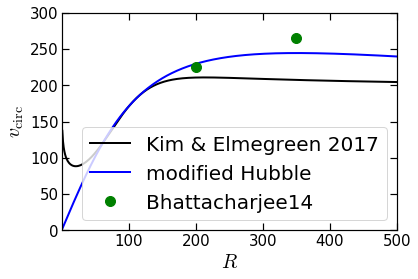

In [40]:
R = np.linspace(1,1000,1000)
vc_KE = vc_KE17(R)
R_b = 120
rho_b = 265
vc = vc_MH(R,R_b,rho_b)

plt.plot(R,vc_KE, label="Kim & Elmegreen 2017")
plt.plot(R,vc, label="modified Hubble")

rp = np.array([200,350])
vp = np.array([225,266])
plt.plot(rp, vp, 'o', label="Bhattacharjee14")

plt.xlim(1,500)
plt.ylim(0,300)
plt.legend()
plt.xlabel(r"$R$")
plt.ylabel(r"$v_{\rm circ}$")

___

## As a fiducial model, we choose inflow rate of $\dot{M}_{\rm in} = 1\,M_\odot\,{\rm yr}^{-1}$
## Computational domain is $L_x=L_y=600\,{\rm pc}$, $L_z=1200\,{\rm pc}$ with 4.7 pc resolution (Mesh : 128x128x256)

In [41]:
base="/home/smoon/data/gc/"
model="M1_4pc"

In [52]:
i=1276
ds=pa.AthenaDataSet(base+model+"/joined/gc.{:04d}.vtk".format(i))
# This is domain information
time=(ds.domain['time']*unit['time']).to(u.Myr)
xmin=ds.domain['left_edge']
xmax=ds.domain['right_edge']
dx=ds.domain['dx']
Nx=ds.domain['Nx']
# set up cell centered coordinates
x=np.arange(xmin[0],xmax[0],dx[0])+0.5*dx[0]
y=np.arange(xmin[1],xmax[1],dx[1])+0.5*dx[1]
z=np.arange(xmin[2],xmax[2],dx[2])+0.5*dx[2]
# This sets up for image plots based on the domain physical size
xyextent=[xmin[0],xmax[0],xmin[1],xmax[1]]
xzextent=[xmin[0],xmax[0],xmin[2],xmax[2]]
yzextent=[xmin[1],xmax[1],xmin[2],xmax[2]]
dx=dx*unit['length']
x=x*unit['length']
y=y*unit['length']
z=z*unit['length']
# Load data
rho=(ds.read_all_data('density')*unit['density']).to(u.M_sun/u.pc**3)
den=(rho/unit['muH']).to(u.cm**-3)
T=ds.read_all_data('temperature')*unit['temperature']
prs=ds.read_all_data('pressure')*unit['pressure']
pok=(prs/c.k_B).to(u.K/u.cm**3)
surfxy=((rho*dx[2]).sum(axis=0)).to(u.M_sun/u.pc**2)
surfxz=((rho*dx[1]).sum(axis=1)).to(u.M_sun/u.pc**2)
sp=pa.read_starvtk(ds.starfile)

## Density projection and temperature slice

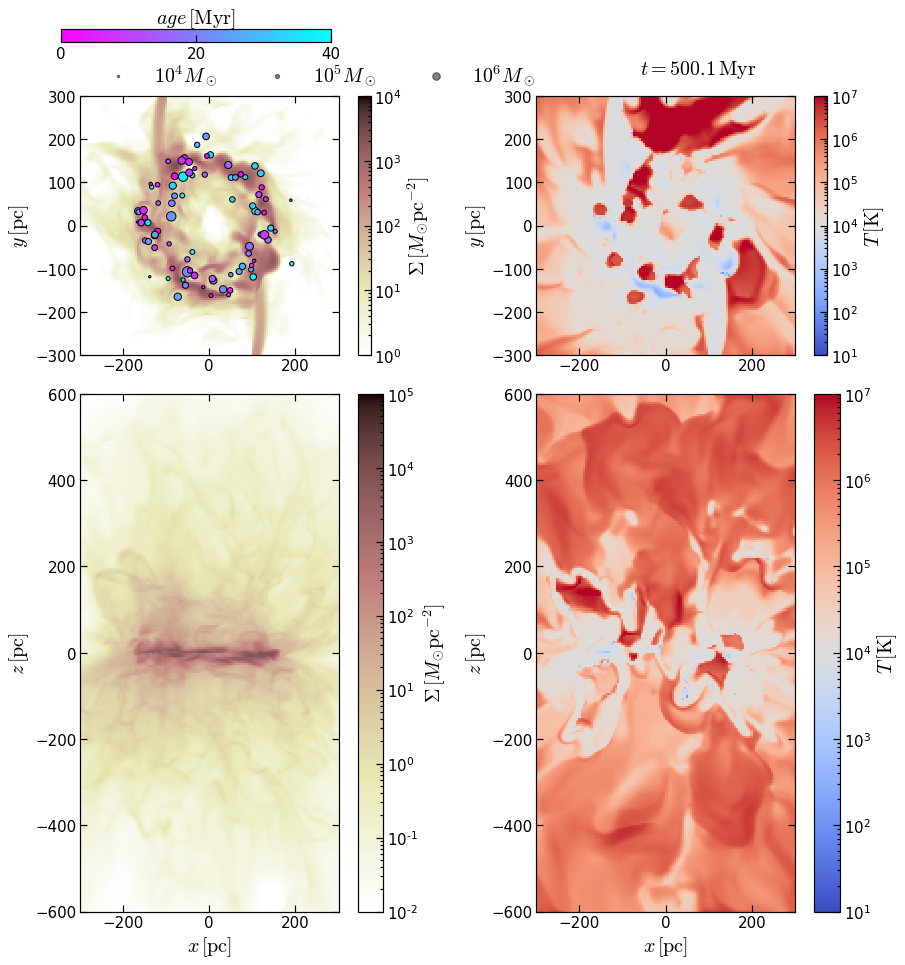

In [53]:
fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(2,2,figure=fig,height_ratios=[1,2],hspace=0.1)
ax=np.ndarray((2,2),dtype=object)
ax[0,0] = fig.add_subplot(gs[0,0])
ax[0,1] = fig.add_subplot(gs[0,1])
ax[1,0] = fig.add_subplot(gs[1,0])
ax[1,1] = fig.add_subplot(gs[1,1])

ax[0,0].set_xlim(xmin[0],xmax[0])
ax[0,0].set_ylim(xmin[1],xmax[1])
ax[0,1].set_xlim(xmin[0],xmax[0])
ax[0,1].set_ylim(xmin[1],xmax[1])
ax[1,0].set_xlim(xmin[0],xmax[0])
ax[1,0].set_ylim(xmin[2],xmax[2])
ax[1,1].set_xlim(xmin[0],xmax[0])
ax[1,1].set_ylim(xmin[2],xmax[2])

# xy projection
proj_xy=ax[0,0].imshow(surfxy,norm=LogNorm(),origin='lower',zorder=0,
        extent=xyextent,cmap='pink_r',clim=[1.e0,1.e4])
cbar=plt.colorbar(proj_xy,ax=ax[0,0])
cbar.set_label(r'$\Sigma\,[M_{\odot} {\rm pc}^{-2}]$')
ax[0,0].set_ylabel(r'$y\,[{\rm pc}]$')
cl=sp_plot(ax[0,0],sp,proj='z')
sp_legend(ax[0,0])

# xy slice
slice_xy=ax[0,1].imshow(T[Nx[2]>>1,:,:],norm=LogNorm(),origin='lower',zorder=0,
        extent=xyextent,cmap='coolwarm',clim=[1e1,1e7])
cbar=plt.colorbar(slice_xy,ax=ax[0,1])
cbar.set_label(r'$T\,[{\rm K}]$')
ax[0,1].set_ylabel(r'$y\,[{\rm pc}]$')

# xz projection
proj_xz=ax[1,0].imshow(surfxz,norm=LogNorm(),origin='lower',zorder=0,
        extent=xzextent,cmap='pink_r',clim=[1.e-2,1.e5])
cbar=plt.colorbar(proj_xz,ax=ax[1,0])
cbar.set_label(r'$\Sigma\,[M_{\odot} {\rm pc}^{-2}]$')
ax[1,0].set_xlabel(r'$x\,[{\rm pc}]$')
ax[1,0].set_ylabel(r'$z\,[{\rm pc}]$')

# xz slice
slice_xz=ax[1,1].imshow(T[:,Nx[1]>>1,:],norm=LogNorm(),origin='lower',zorder=0,
        extent=xzextent,cmap='coolwarm',clim=[1e1,1e7])
cbar=plt.colorbar(slice_xz,ax=ax[1,1])
cbar.set_label(r'$T\,[{\rm K}]$')
ax[1,1].set_xlabel(r'$x\,[{\rm pc}]$')
ax[1,1].set_ylabel(r'$z\,[{\rm pc}]$')

# annotations
cax1 = fig.add_axes([0.15, 0.93, 0.25, 0.012]) # [left, bottom, width, height]
cbar=plt.colorbar(cl,ticks=[0,20,40],cax=cax1,orientation='horizontal')
cbar.ax.set_title(r'$age\,[\rm Myr]$')
time_text=ax[0,1].text(-60,350,r'$t={:.1f}\,\rm Myr$'.format(time.value))

## Phase diagram

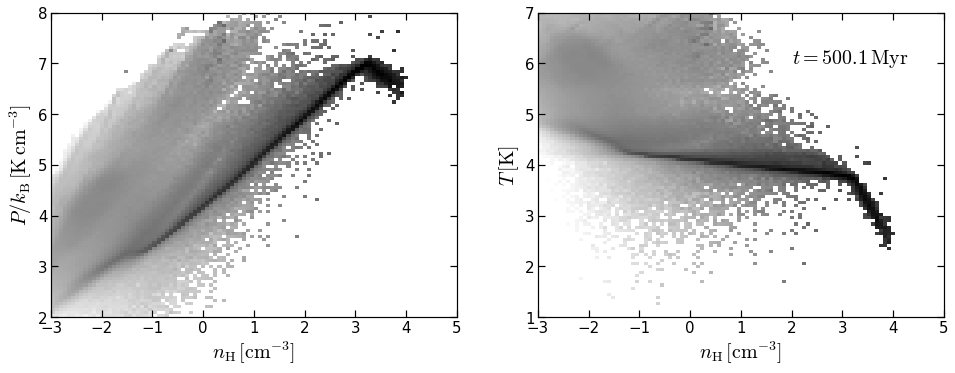

In [54]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
nmin=-3; nmax=5; Pmin=2; Pmax=8; Tmin=1; Tmax=7
H,xedges,yedges=histogram2d(np.log10(den.flatten().value),
        np.log10(pok.flatten().value),bins=100,
        range=[[nmin,nmax],[Pmin,Pmax]],density=True,
        weights=den.flatten().value)
nP=ax[0].imshow(H.T,origin='lower',norm=LogNorm(),
        extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]],cmap='Greys')
H,xedges,yedges=histogram2d(np.log10(den.flatten().value),
        np.log10(T.flatten().value),bins=100,
        range=[[nmin,nmax],[Tmin,Tmax]],density=True,
        weights=den.flatten().value)
TP=ax[1].imshow(H.T,origin='lower',norm=LogNorm(),
        extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]],cmap='Greys')
ax[0].set_xlabel(r'$n_{\rm H}\,[{\rm cm}^{-3}]$')
ax[0].set_ylabel(r'$P/k_{\rm B}\,[{\rm K\,cm^{-3}}]$')
ax[1].set_xlabel(r'$n_{\rm H}\,[{\rm cm}^{-3}]$')
ax[1].set_ylabel(r'$T\,[{\rm K}]$')
time_text=ax[1].text(2,6,r'$t={:.1f}\,\rm Myr$'.format(time.value))

## Star formation rate and gas mass versus time

In [55]:
Lx=600; Ly=600; Lz=1200
vol=Lx*Ly*Lz
hst=np.loadtxt(base+model+"/joined/id0/gc.hst")
t = hst[:,0]*unit['time']
Mtot = hst[:,2]*vol*unit['mass']
Pth = hst[:,38]*unit['pressure']
Pturb = hst[:,40]*unit['pressure']
Mw = hst[:,51]*vol*unit['mass']
Mu = hst[:,52]*vol*unit['mass']
Mc = hst[:,53]*vol*unit['mass']
Ms = hst[:,57]*vol*unit['mass']
sigsfr = hst[:,54]*u.M_sun/u.Myr/u.pc**2
sfr = (sigsfr*Lx*Ly*u.pc**2).to(u.M_sun/u.yr)

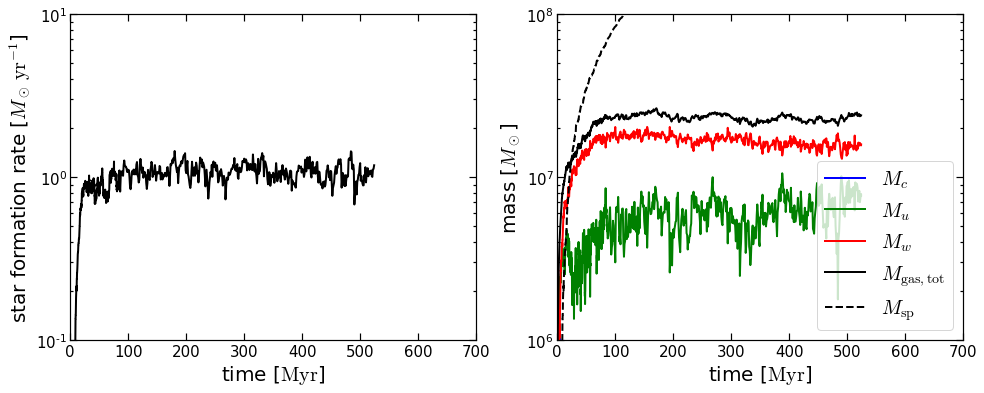

In [56]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].semilogy(t, sfr, 'k-')
ax[0].set_xlabel("time ["+r"${\rm Myr}$"+"]")
ax[0].set_ylabel("star formation rate ["+r"$M_\odot\,{\rm yr}^{-1}$"+"]")
ax[0].set_xlim(0,700)
ax[0].set_ylim(1e-1,1e1)
ax[1].semilogy(t, Mc, 'b-', label=r"$M_c$")
ax[1].semilogy(t, Mu, 'g-', label=r"$M_u$")
ax[1].semilogy(t, Mw, 'r-', label=r"$M_w$")
ax[1].semilogy(t, Mtot, 'k-', label=r"$M_{\rm gas, tot}$")
ax[1].semilogy(t, Ms, 'k--', label=r"$M_{\rm sp}$")
ax[1].set_xlabel("time ["+r"${\rm Myr}$"+"]")
ax[1].set_ylabel("mass ["+r"${M_\odot}$"+"]")
ax[1].set_xlim(0,700)
ax[1].set_ylim(1e6,1e8)
ax[1].legend()

## As can be noticed from the phase diagram, significant amount of the cold phase gas is missing. This is because Larson-Penston threshold density at the present resolution (4.7 pc) is lower than the minimum density of the cold phase gas.

## To investigate this in more detail, we plot the Larson-Penston threshold density on the equilibrium phase diagram

Text(12000.0, 2000.0, '$\\Delta x=2\\,{\\rm pc}$')

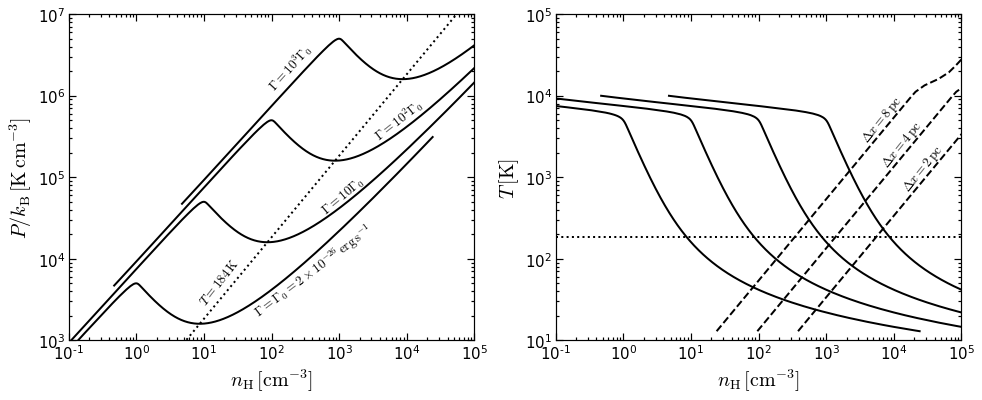

In [57]:
cf=cooling.coolftn()
coolft=interp1d(cf.temp,cf.cool)
heatft=interp1d(cf.temp,cf.heat)
muft=interp1d(cf.temp,cf.temp/cf.T1)

heat_ratio=[1e0,1e1,1e2,1e3]
muH=1.4271

N=1000
n=np.logspace(-1,5,N)
Teq=np.zeros(N)
fig,ax=plt.subplots(1,2,figsize=(16,6))

ax[0].loglog(n,n*184,'k:')
ax[1].loglog(n,184*np.ones(len(n)),'k:')
for j in range(4):
    for i in range(N):
        try:
            Teq[i]=bisect(lambda x: heat_ratio[j]*heatft(x)/n[i]-coolft(x)
                    ,12.95,1e4)
        except:
            Teq[i]=np.nan
    Peq=n*Teq
    ax[0].loglog(n,Peq,'k-')
    ax[1].loglog(n,Teq,'k-')
dxs=[8*u.pc,4*u.pc,2*u.pc]
Teq=np.logspace(np.log10(12.95),5)
cs2=c.k_B*(Teq*u.K)/muft(Teq)/c.m_p
for dx in dxs:
    nth=(8.86/np.pi*cs2/c.G/dx**2/muH/c.m_p).to(u.cm**-3).value
    ax[1].loglog(nth,Teq,'k--')

ax[0].set_xlim(1e-1,1e5)
ax[0].set_ylim(1e3,1e7)
ax[0].set_xlabel(r'$n_{\rm H}\,[{\rm cm}^{-3}]$')
ax[0].set_ylabel(r'$P/k_{\rm B}\,[{\rm K\,cm^{-3}}]$')
ax[1].set_xlim(1e-1,1e5)
ax[1].set_ylim(1e1,1e5)
ax[1].set_xlabel(r'$n_{\rm H}\,[{\rm cm}^{-3}]$')
ax[1].set_ylabel(r'$T\,[{\rm K}]$')
ax[0].text(5e1,2e4,
        r"$\Gamma=\Gamma_0=2\times 10^{-26}\,{\rm erg\,s^{-1}}$",
        fontsize=13,rotation=37)
ax[0].text(5e2,8e4,r"$\Gamma=10\Gamma_0$",fontsize=13,rotation=40)
ax[0].text(3e3,7e5,r"$\Gamma=10^2\Gamma_0$",fontsize=13,rotation=38)
ax[0].text(0.8e2,3.3e6,r"$\Gamma=10^3\Gamma_0$",fontsize=13,rotation=48)
ax[0].text(0.8e1,0.8e4,r"$T=184\,{\rm K}$",fontsize=13,rotation=52)
ax[1].text(3e3,8e3,r"$\Delta x=8\,{\rm pc}$",fontsize=13,rotation=51)
ax[1].text(6e3,4e3,r"$\Delta x=4\,{\rm pc}$",fontsize=13,rotation=51)
ax[1].text(1.2e4,2e3,r"$\Delta x=2\,{\rm pc}$",fontsize=13,rotation=51)

## Left panel shows how the pressure-density relation varies with the FUV intensity. The two-phase pressure scales nearly linearly with FUV intensity, and the maximum temperature of the cold phase medium remains constant at $\sim 184\,{\rm K}$.

## Right panel shows the corresponding temperature-density relation. Larson-Penston density threshold is shown in dahsed lines, with spatial resolution $8\,{\rm pc}$, $4\,{\rm pc}$, and $2\,{\rm pc}$. In the Solar-neighborhood model, the FUV intensity is $1-10\,{\rm \Gamma}_0$, which corresponds to the first two lines from the left. It can be seen that the Larson-Penston threshold density is always higher than the minimum cold phase density, ensuring that the star formation occur in the cold phase gas. However, in the galactic center model, the FUV intensity is somewhat greater thatn $10^3\,{\rm \Gamma}_0$, which corresponds to the rightmost line. In this case, the Larson-Penston density threshold is smaller than the minium cold phase density even with $2\,{\rm pc}$ resolution. This means the star formation is already occuring in the unstable phase gas, thus preventing cold gas formation.

## We may place additional SF criterion by requiring $T < T_{\rm th}$, ensuring that the star formation occur in the cold phase. Below we show how the result changes when we do this with $T_{\rm th} = 50\,{\rm K}$.

In [58]:
model="M1_4pc_Tth50"
i=500
ds=pa.AthenaDataSet(base+model+"/joined/gc.{:04d}.vtk".format(i))
time=(ds.domain['time']*unit['time']).to(u.Myr)
xmin=ds.domain['left_edge']
xmax=ds.domain['right_edge']
dx=ds.domain['dx']
Nx=ds.domain['Nx']
# set up cell centered coordinates
x=np.arange(xmin[0],xmax[0],dx[0])+0.5*dx[0]
y=np.arange(xmin[1],xmax[1],dx[1])+0.5*dx[1]
z=np.arange(xmin[2],xmax[2],dx[2])+0.5*dx[2]
# This sets up for image plots based on the domain physical size
xyextent=[xmin[0],xmax[0],xmin[1],xmax[1]]
xzextent=[xmin[0],xmax[0],xmin[2],xmax[2]]
yzextent=[xmin[1],xmax[1],xmin[2],xmax[2]]
dx=dx*unit['length']
x=x*unit['length']
y=y*unit['length']
z=z*unit['length']
# Load data
rho=(ds.read_all_data('density')*unit['density']).to(u.M_sun/u.pc**3)
den=(rho/unit['muH']).to(u.cm**-3)
T=ds.read_all_data('temperature')*unit['temperature']
prs=ds.read_all_data('pressure')*unit['pressure']
pok=(prs/c.k_B).to(u.K/u.cm**3)
surfxy=((rho*dx[2]).sum(axis=0)).to(u.M_sun/u.pc**2)
surfxz=((rho*dx[1]).sum(axis=1)).to(u.M_sun/u.pc**2)
sp=pa.read_starvtk(ds.starfile)

## Density projection and temperature slice

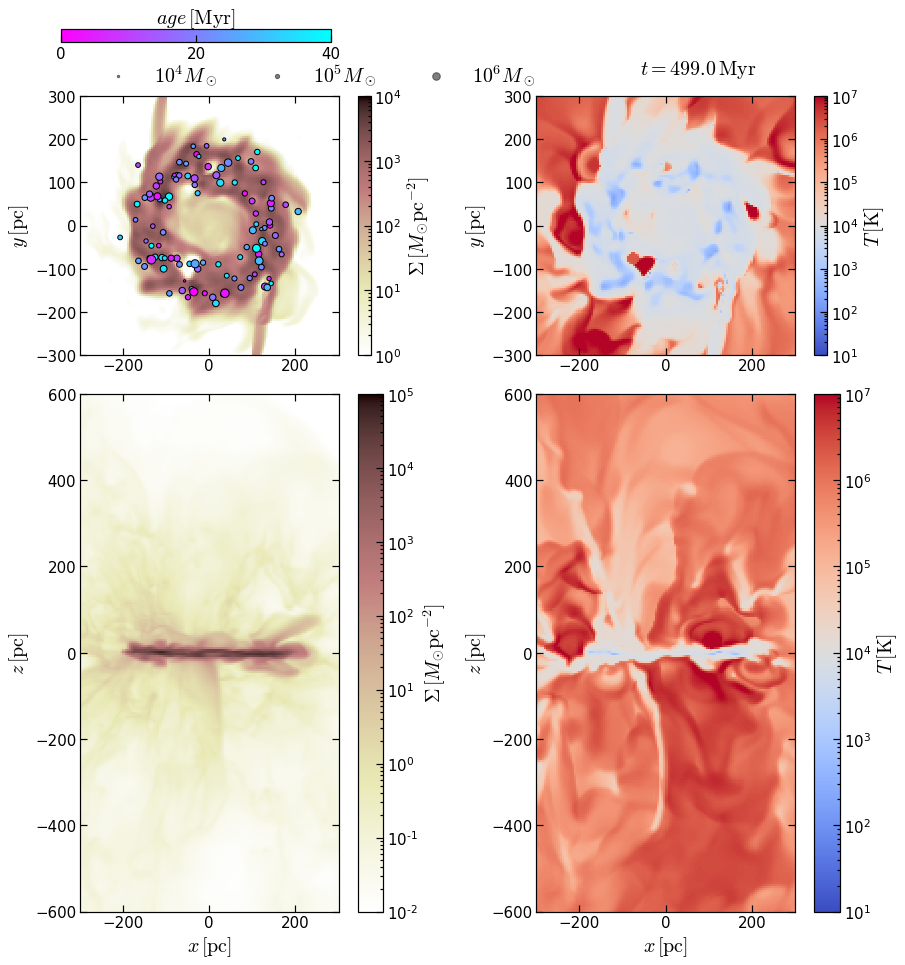

In [59]:
fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(2,2,figure=fig,height_ratios=[1,2],hspace=0.1)
ax=np.ndarray((2,2),dtype=object)
ax[0,0] = fig.add_subplot(gs[0,0])
ax[0,1] = fig.add_subplot(gs[0,1])
ax[1,0] = fig.add_subplot(gs[1,0])
ax[1,1] = fig.add_subplot(gs[1,1])

ax[0,0].set_xlim(xmin[0],xmax[0])
ax[0,0].set_ylim(xmin[1],xmax[1])
ax[0,1].set_xlim(xmin[0],xmax[0])
ax[0,1].set_ylim(xmin[1],xmax[1])
ax[1,0].set_xlim(xmin[0],xmax[0])
ax[1,0].set_ylim(xmin[2],xmax[2])
ax[1,1].set_xlim(xmin[0],xmax[0])
ax[1,1].set_ylim(xmin[2],xmax[2])

# xy projection
proj_xy=ax[0,0].imshow(surfxy,norm=LogNorm(),origin='lower',zorder=0,
        extent=xyextent,cmap='pink_r',clim=[1.e0,1.e4])
cbar=plt.colorbar(proj_xy,ax=ax[0,0])
cbar.set_label(r'$\Sigma\,[M_{\odot} {\rm pc}^{-2}]$')
ax[0,0].set_ylabel(r'$y\,[{\rm pc}]$')
cl=sp_plot(ax[0,0],sp,proj='z')
sp_legend(ax[0,0])

# xy slice
slice_xy=ax[0,1].imshow(T[Nx[2]>>1,:,:],norm=LogNorm(),origin='lower',zorder=0,
        extent=xyextent,cmap='coolwarm',clim=[1e1,1e7])
cbar=plt.colorbar(slice_xy,ax=ax[0,1])
cbar.set_label(r'$T\,[{\rm K}]$')
ax[0,1].set_ylabel(r'$y\,[{\rm pc}]$')

# xz projection
proj_xz=ax[1,0].imshow(surfxz,norm=LogNorm(),origin='lower',zorder=0,
        extent=xzextent,cmap='pink_r',clim=[1.e-2,1.e5])
cbar=plt.colorbar(proj_xz,ax=ax[1,0])
cbar.set_label(r'$\Sigma\,[M_{\odot} {\rm pc}^{-2}]$')
ax[1,0].set_xlabel(r'$x\,[{\rm pc}]$')
ax[1,0].set_ylabel(r'$z\,[{\rm pc}]$')

# xz slice
slice_xz=ax[1,1].imshow(T[:,Nx[1]>>1,:],norm=LogNorm(),origin='lower',zorder=0,
        extent=xzextent,cmap='coolwarm',clim=[1e1,1e7])
cbar=plt.colorbar(slice_xz,ax=ax[1,1])
cbar.set_label(r'$T\,[{\rm K}]$')
ax[1,1].set_xlabel(r'$x\,[{\rm pc}]$')
ax[1,1].set_ylabel(r'$z\,[{\rm pc}]$')

# annotations
cax1 = fig.add_axes([0.15, 0.93, 0.25, 0.012]) # [left, bottom, width, height]
cbar=plt.colorbar(cl,ticks=[0,20,40],cax=cax1,orientation='horizontal')
cbar.ax.set_title(r'$age\,[\rm Myr]$')
time_text=ax[0,1].text(-60,350,r'$t={:.1f}\,\rm Myr$'.format(time.value))

## Phase diagram

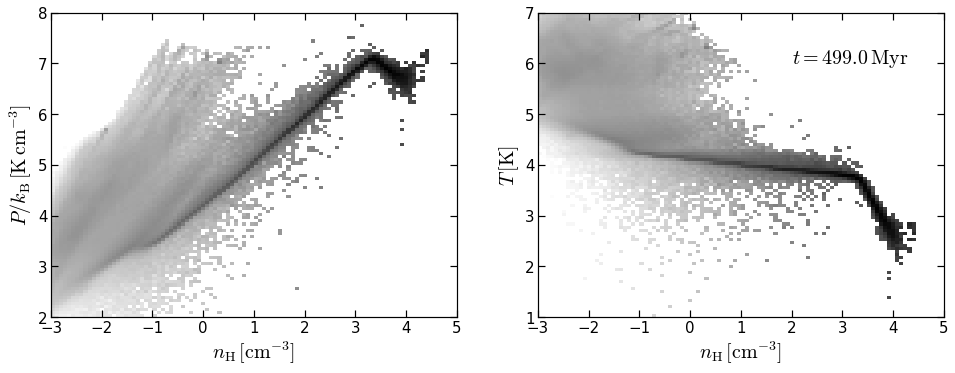

In [60]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
nmin=-3; nmax=5; Pmin=2; Pmax=8; Tmin=1; Tmax=7
H,xedges,yedges=histogram2d(np.log10(den.flatten().value),
        np.log10(pok.flatten().value),bins=100,
        range=[[nmin,nmax],[Pmin,Pmax]],density=True,
        weights=den.flatten().value)
nP=ax[0].imshow(H.T,origin='lower',norm=LogNorm(),
        extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]],cmap='Greys')
H,xedges,yedges=histogram2d(np.log10(den.flatten().value),
        np.log10(T.flatten().value),bins=100,
        range=[[nmin,nmax],[Tmin,Tmax]],density=True,
        weights=den.flatten().value)
TP=ax[1].imshow(H.T,origin='lower',norm=LogNorm(),
        extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]],cmap='Greys')
ax[0].set_xlabel(r'$n_{\rm H}\,[{\rm cm}^{-3}]$')
ax[0].set_ylabel(r'$P/k_{\rm B}\,[{\rm K\,cm^{-3}}]$')
ax[1].set_xlabel(r'$n_{\rm H}\,[{\rm cm}^{-3}]$')
ax[1].set_ylabel(r'$T\,[{\rm K}]$')
time_text=ax[1].text(2,6,r'$t={:.1f}\,\rm Myr$'.format(time.value))

## Star formation rate and gas mass versus time

In [61]:
Lx=600; Ly=600; Lz=1200
vol=Lx*Ly*Lz
hst=np.loadtxt(base+model+"/joined/id0/gc.hst")
t = hst[:,0]*unit['time']
Mtot = hst[:,2]*vol*unit['mass']
Pth = hst[:,38]*unit['pressure']
Pturb = hst[:,40]*unit['pressure']
Mw = hst[:,51]*vol*unit['mass']
Mu = hst[:,52]*vol*unit['mass']
Mc = hst[:,53]*vol*unit['mass']
Ms = hst[:,57]*vol*unit['mass']
sigsfr = hst[:,54]*u.M_sun/u.Myr/u.pc**2
sfr = (sigsfr*Lx*Ly*u.pc**2).to(u.M_sun/u.yr)

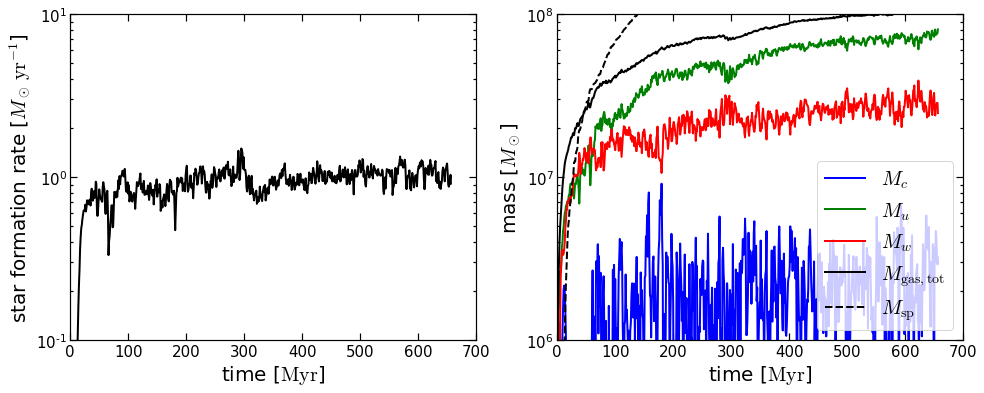

In [62]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].semilogy(t, sfr, 'k-')
ax[0].set_xlabel("time ["+r"${\rm Myr}$"+"]")
ax[0].set_ylabel("star formation rate ["+r"$M_\odot\,{\rm yr}^{-1}$"+"]")
ax[0].set_xlim(0,700)
ax[0].set_ylim(1e-1,1e1)
ax[1].semilogy(t, Mc, 'b-', label=r"$M_c$")
ax[1].semilogy(t, Mu, 'g-', label=r"$M_u$")
ax[1].semilogy(t, Mw, 'r-', label=r"$M_w$")
ax[1].semilogy(t, Mtot, 'k-', label=r"$M_{\rm gas, tot}$")
ax[1].semilogy(t, Ms, 'k--', label=r"$M_{\rm sp}$")
ax[1].set_xlabel("time ["+r"${\rm Myr}$"+"]")
ax[1].set_ylabel("mass ["+r"${M_\odot}$"+"]")
ax[1].set_xlim(0,700)
ax[1].set_ylim(1e6,1e8)
ax[1].legend()

## With $T < 50\,{\rm K}$ additional SF criterion, the cold and unstable phase gas fraction significantly increase as well as total gas mass. However, star formation rate remains the same. Regardless of the SF criterion, the star formation rate always converge to the mass inflow rate with very small fluctuation. This is shown in the below.

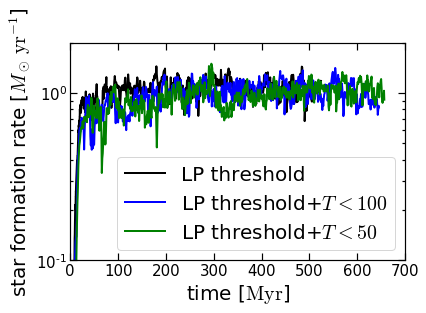

In [63]:
model="M1_4pc"
hst=np.loadtxt(base+model+"/joined/id0/gc.hst")
Lx=600; Ly=600; Lz=1200
vol=Lx*Ly*Lz
t = hst[:,0]*unit['time']
sigsfr = hst[:,54]*u.M_sun/u.Myr/u.pc**2
sfr = (sigsfr*Lx*Ly*u.pc**2).to(u.M_sun/u.yr)
plt.semilogy(t,sfr,label="LP threshold")
model="M1_4pc_Tth100"
hst=np.loadtxt(base+model+"/joined/id0/gc.hst")
Lx=600; Ly=600; Lz=1200
vol=Lx*Ly*Lz
t = hst[:,0]*unit['time']
sigsfr = hst[:,54]*u.M_sun/u.Myr/u.pc**2
sfr = (sigsfr*Lx*Ly*u.pc**2).to(u.M_sun/u.yr)
plt.semilogy(t,sfr,label="LP threshold+"+r"$T<100$")
model="M1_4pc_Tth50"
hst=np.loadtxt(base+model+"/joined/id0/gc.hst")
Lx=600; Ly=600; Lz=1200
vol=Lx*Ly*Lz
t = hst[:,0]*unit['time']
sigsfr = hst[:,54]*u.M_sun/u.Myr/u.pc**2
sfr = (sigsfr*Lx*Ly*u.pc**2).to(u.M_sun/u.yr)
plt.semilogy(t,sfr,label="LP threshold+"+r"$T<50$")
plt.xlim(0,700)
plt.ylim(1e-1,2e0)
plt.xlabel("time ["+r"${\rm Myr}$"+"]")
plt.ylabel("star formation rate ["+r"$M_\odot\,{\rm yr}^{-1}$"+"]")
plt.legend(fontsize=20)

___

## Lower inflow rate : $\dot{M}_{\rm in} = 0.1\,M_\odot\,{\rm yr}^{-1}$ (with $T<50\,{\rm K}$ criterion)

In [64]:
model="M0.1_4pc_Tth50"
i=500
ds=pa.AthenaDataSet(base+model+"/joined/gc.{:04d}.vtk".format(i))
time=(ds.domain['time']*unit['time']).to(u.Myr)
xmin=ds.domain['left_edge']
xmax=ds.domain['right_edge']
dx=ds.domain['dx']
Nx=ds.domain['Nx']
# set up cell centered coordinates
x=np.arange(xmin[0],xmax[0],dx[0])+0.5*dx[0]
y=np.arange(xmin[1],xmax[1],dx[1])+0.5*dx[1]
z=np.arange(xmin[2],xmax[2],dx[2])+0.5*dx[2]
# This sets up for image plots based on the domain physical size
xyextent=[xmin[0],xmax[0],xmin[1],xmax[1]]
xzextent=[xmin[0],xmax[0],xmin[2],xmax[2]]
yzextent=[xmin[1],xmax[1],xmin[2],xmax[2]]
dx=dx*unit['length']
x=x*unit['length']
y=y*unit['length']
z=z*unit['length']
# Load data
rho=(ds.read_all_data('density')*unit['density']).to(u.M_sun/u.pc**3)
den=(rho/unit['muH']).to(u.cm**-3)
T=ds.read_all_data('temperature')*unit['temperature']
prs=ds.read_all_data('pressure')*unit['pressure']
pok=(prs/c.k_B).to(u.K/u.cm**3)
surfxy=((rho*dx[2]).sum(axis=0)).to(u.M_sun/u.pc**2)
surfxz=((rho*dx[1]).sum(axis=1)).to(u.M_sun/u.pc**2)
sp=pa.read_starvtk(ds.starfile)

## Density projection and temperature slice

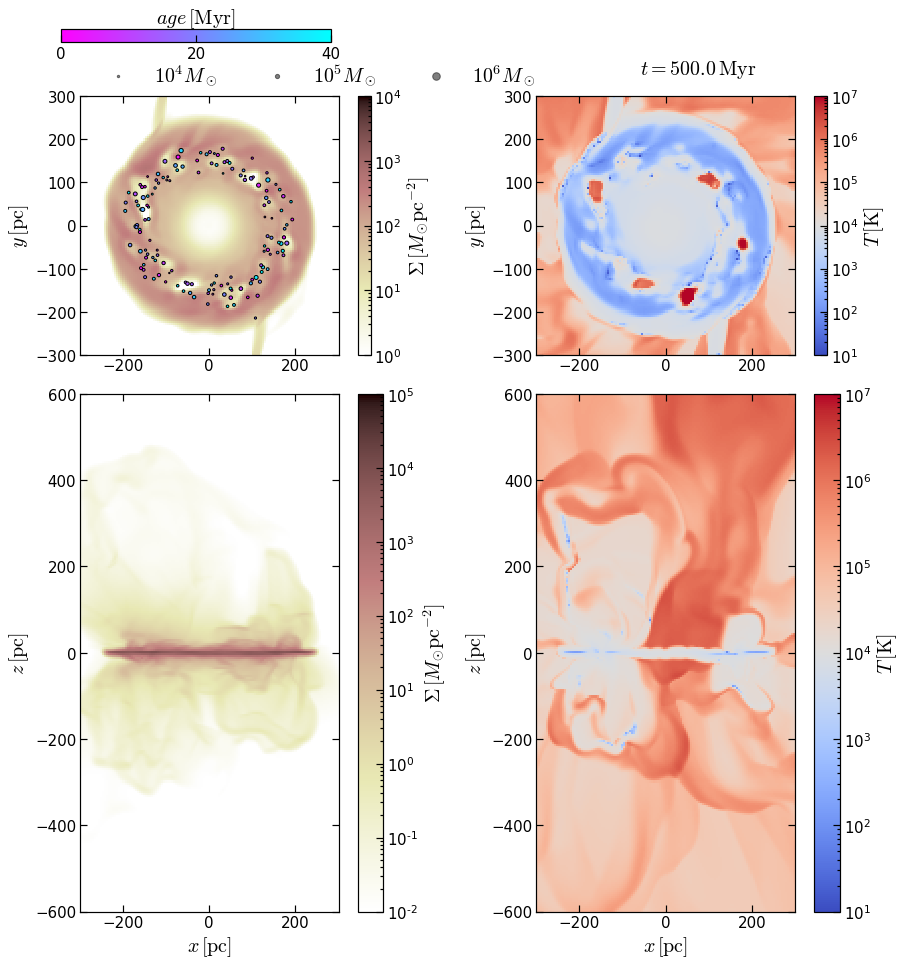

In [65]:
fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(2,2,figure=fig,height_ratios=[1,2],hspace=0.1)
ax=np.ndarray((2,2),dtype=object)
ax[0,0] = fig.add_subplot(gs[0,0])
ax[0,1] = fig.add_subplot(gs[0,1])
ax[1,0] = fig.add_subplot(gs[1,0])
ax[1,1] = fig.add_subplot(gs[1,1])

ax[0,0].set_xlim(xmin[0],xmax[0])
ax[0,0].set_ylim(xmin[1],xmax[1])
ax[0,1].set_xlim(xmin[0],xmax[0])
ax[0,1].set_ylim(xmin[1],xmax[1])
ax[1,0].set_xlim(xmin[0],xmax[0])
ax[1,0].set_ylim(xmin[2],xmax[2])
ax[1,1].set_xlim(xmin[0],xmax[0])
ax[1,1].set_ylim(xmin[2],xmax[2])

# xy projection
proj_xy=ax[0,0].imshow(surfxy,norm=LogNorm(),origin='lower',zorder=0,
        extent=xyextent,cmap='pink_r',clim=[1.e0,1.e4])
cbar=plt.colorbar(proj_xy,ax=ax[0,0])
cbar.set_label(r'$\Sigma\,[M_{\odot} {\rm pc}^{-2}]$')
ax[0,0].set_ylabel(r'$y\,[{\rm pc}]$')
cl=sp_plot(ax[0,0],sp,proj='z')
sp_legend(ax[0,0])

# xy slice
slice_xy=ax[0,1].imshow(T[Nx[2]>>1,:,:],norm=LogNorm(),origin='lower',zorder=0,
        extent=xyextent,cmap='coolwarm',clim=[1e1,1e7])
cbar=plt.colorbar(slice_xy,ax=ax[0,1])
cbar.set_label(r'$T\,[{\rm K}]$')
ax[0,1].set_ylabel(r'$y\,[{\rm pc}]$')

# xz projection
proj_xz=ax[1,0].imshow(surfxz,norm=LogNorm(),origin='lower',zorder=0,
        extent=xzextent,cmap='pink_r',clim=[1.e-2,1.e5])
cbar=plt.colorbar(proj_xz,ax=ax[1,0])
cbar.set_label(r'$\Sigma\,[M_{\odot} {\rm pc}^{-2}]$')
ax[1,0].set_xlabel(r'$x\,[{\rm pc}]$')
ax[1,0].set_ylabel(r'$z\,[{\rm pc}]$')

# xz slice
slice_xz=ax[1,1].imshow(T[:,Nx[1]>>1,:],norm=LogNorm(),origin='lower',zorder=0,
        extent=xzextent,cmap='coolwarm',clim=[1e1,1e7])
cbar=plt.colorbar(slice_xz,ax=ax[1,1])
cbar.set_label(r'$T\,[{\rm K}]$')
ax[1,1].set_xlabel(r'$x\,[{\rm pc}]$')
ax[1,1].set_ylabel(r'$z\,[{\rm pc}]$')

# annotations
cax1 = fig.add_axes([0.15, 0.93, 0.25, 0.012]) # [left, bottom, width, height]
cbar=plt.colorbar(cl,ticks=[0,20,40],cax=cax1,orientation='horizontal')
cbar.ax.set_title(r'$age\,[\rm Myr]$')
time_text=ax[0,1].text(-60,350,r'$t={:.1f}\,\rm Myr$'.format(time.value))

## Phase diagram

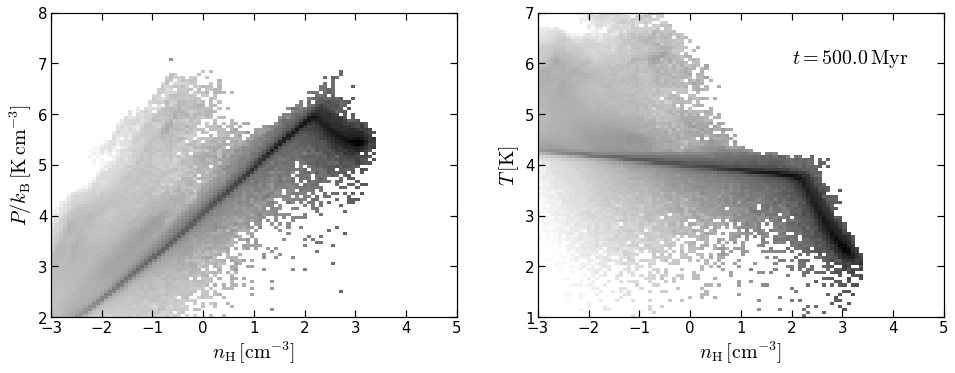

In [66]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
nmin=-3; nmax=5; Pmin=2; Pmax=8; Tmin=1; Tmax=7
H,xedges,yedges=histogram2d(np.log10(den.flatten().value),
        np.log10(pok.flatten().value),bins=100,
        range=[[nmin,nmax],[Pmin,Pmax]],density=True,
        weights=den.flatten().value)
nP=ax[0].imshow(H.T,origin='lower',norm=LogNorm(),
        extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]],cmap='Greys')
H,xedges,yedges=histogram2d(np.log10(den.flatten().value),
        np.log10(T.flatten().value),bins=100,
        range=[[nmin,nmax],[Tmin,Tmax]],density=True,
        weights=den.flatten().value)
TP=ax[1].imshow(H.T,origin='lower',norm=LogNorm(),
        extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]],cmap='Greys')
ax[0].set_xlabel(r'$n_{\rm H}\,[{\rm cm}^{-3}]$')
ax[0].set_ylabel(r'$P/k_{\rm B}\,[{\rm K\,cm^{-3}}]$')
ax[1].set_xlabel(r'$n_{\rm H}\,[{\rm cm}^{-3}]$')
ax[1].set_ylabel(r'$T\,[{\rm K}]$')
time_text=ax[1].text(2,6,r'$t={:.1f}\,\rm Myr$'.format(time.value))

## Star formation rate and gas mass versus time

In [67]:
Lx=600; Ly=600; Lz=1200
vol=Lx*Ly*Lz
hst=np.loadtxt(base+model+"/joined/id0/gc.hst")
t = hst[:,0]*unit['time']
Mtot = hst[:,2]*vol*unit['mass']
Pth = hst[:,38]*unit['pressure']
Pturb = hst[:,40]*unit['pressure']
Mw = hst[:,51]*vol*unit['mass']
Mu = hst[:,52]*vol*unit['mass']
Mc = hst[:,53]*vol*unit['mass']
Ms = hst[:,57]*vol*unit['mass']
sigsfr = hst[:,54]*u.M_sun/u.Myr/u.pc**2
sfr = (sigsfr*Lx*Ly*u.pc**2).to(u.M_sun/u.yr)

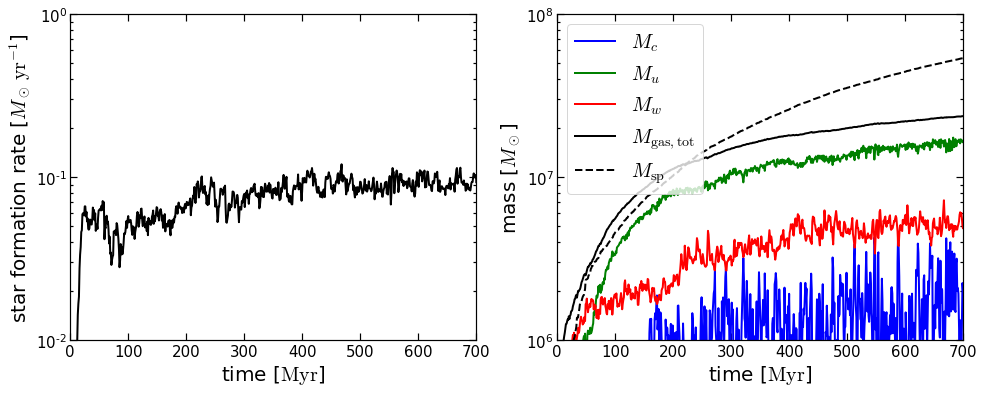

In [68]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].semilogy(t, sfr, 'k-')
ax[0].set_xlabel("time ["+r"${\rm Myr}$"+"]")
ax[0].set_ylabel("star formation rate ["+r"$M_\odot\,{\rm yr}^{-1}$"+"]")
ax[0].set_xlim(0,700)
ax[0].set_ylim(1e-2,1e0)
ax[1].semilogy(t, Mc, 'b-', label=r"$M_c$")
ax[1].semilogy(t, Mu, 'g-', label=r"$M_u$")
ax[1].semilogy(t, Mw, 'r-', label=r"$M_w$")
ax[1].semilogy(t, Mtot, 'k-', label=r"$M_{\rm gas, tot}$")
ax[1].semilogy(t, Ms, 'k--', label=r"$M_{\rm sp}$")
ax[1].set_xlabel("time ["+r"${\rm Myr}$"+"]")
ax[1].set_ylabel("mass ["+r"${M_\odot}$"+"]")
ax[1].set_xlim(0,700)
ax[1].set_ylim(1e6,1e8)
ax[1].legend()

___

# Concluding remarks
* ## Overall, the result indicate that the star formation rate does not fluctuate with high amplitude as we expected.
* ## In high SFR regime such as galactic centers, it is especially challenging to represent cold phase gas with current TIGRESS model because the cold phase density becomes comparable to the Larson-Penston threshold density. However, this may be due to the fact that we didn'tconsider UV shielding.
* ## Star formation rate seems to converge to the mass inflow rate.

___